<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT20/blob/HelmerNylen/Lab-4/HelmerNylen_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 4: Function Approximation**
**Helmer Nylén**

# **Abstract**

In this lab we implement a projection of a scalar function onto the space of pointwise linear functions, and test the accuracy and convergence of the implementation.

#**About the code**

In [68]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2019 Helmer Nylén (helmern@kth.se)
# Concepts of this lab were discussed with Jonas Nylund

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [0]:
# Load neccessary modules.
import numpy as np
import numpy.polynomial.polynomial as P
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve
from random import randint
from functools import reduce

# **Introduction**

In this lab we implement $L^2$-projection of a scalar function $f$ onto a continuous pointwise linear approximation over a 1D mesh.

# **Methods**

We largely follow example 9.11, chapter 9.3 in the lecture notes for the theory behind our implementation, and the goal is to find the solution vector $\alpha = (\alpha_j)$ in equation 9.13. We can do this by solving $A\alpha = b$ for $\alpha$ after constructing $A$ and $b$.

Let the mesh consist of points $x_0 < x_1 < \ldots < x_{m+1}$. If we let $h_i = x_i - x_{i-1}$ for $i = 1, \ldots, m+1$ be the width of interval $i$, equations 9.14-16 yield the following definition of $A$:
$$a_{ij} = \begin{cases}
    \frac{h_i + h_{i+1}}{3}, &\text{if }j = i \\
    \frac{h_{i+1}}{6}, &\text{if }j = i+1 \\
    \frac{h_i}{6}, &\text{if }j = i-1 \\
    0, &\text{otherwise}
\end{cases},\text{ for } i = 1, \ldots, m$$

At the edge cases we have
\begin{align}
a_{00} &= \int_0^1 \phi_0^2(x)dx = \int_{I_1} \lambda_{1, 0}^2(x)dx = \ldots = \frac{h_1}{3} \\
a_{01} &= \frac{h_1}{6} \\
a_{m+1,m+1} &= \int_0^1 \phi_{m+1}^2(x)dx = \int_{I_{m+1}} \lambda_{m+1, 1}^2(x)dx = \ldots = \frac{h_{m+1}}{3} \\
a_{m+1, m} &= \frac{h_{m+1}}{6}
\end{align}
where we have used the definition of $\phi_i$ in example 9.6.

Now we need to compute $b$. Equation 9.17 states that
$$b_i = (f, \phi_i) = \int_0^1 f(x) \phi_i(x)dx,$$
and the lecture notes suggest we use the approximation $$f \approx \pi_h f$$ in our computations. From page 167 in the lecture notes we have that
$$\pi_h f(x) = \sum_{i=0}^{m+1} f(x_i) \phi_i(x).$$
It follows that
\begin{align}
b_i = (f, \phi_i) &= \int_0^1 f(x)\phi_i(x)dx \approx \int_0^1 \left(\sum_{j=0}^{m+1} f(x_j)\phi_j(x)\right) \phi_i(x)dx\\
&=\sum_{j=0}^{m+1} f(x_j)\underbrace{\int_0^1\phi_j(x)\phi_i(x)dx}_{a_{ji}\ (=\ a_{ij})}=\sum_{j=0}^{m+1} f(x_j) a_{ij}.
\end{align}
Using $x = \{x_i\}_{i=0}^n$ and $f(x) = \{f(x_i)\}_{i=0}^n$ we can write this result as $$b = A f(x).$$

Considering $A$ is sparse and only has elements along the main, sub- and superdiagonal we can simplify this as $$b_i = \sum_{j=\max(i-1, 0)}^{\min(i+1, m+1)} f(x_j) a_{ij}$$ to lessen the number of computations. If we use a sparse data structure for $A$ we can reasonably assume that this optimisation is already done for us and keep $b = Af(x)$ for brevity.

In [0]:
def _assemble_system(f, mesh):
  assert hasattr(f, "__call__")
  assert type(mesh) is np.ndarray and len(mesh.shape) == 1 and len(mesh) >= 3 and (np.diff(mesh) > 0).all()
  m = len(mesh) - 2                     # Number of internal modes
  h = lambda i: mesh[i] - mesh[i - 1]   # Size of interval i

  # Initialize A as a sparse CSR matrix with ones along the super-, sub- and main diagonal
  # These are overwritten by the loop
  A = sparse.diags(([1] * (m + 1), [1] * (m + 2), [1] * (m + 1)), [-1, 0, 1]).tocsr()

  for i in range(1, m + 1):
    for j in range(i - 1, i + 2):
      if j == i + 1:
        A[i, j] = h(i+1) / 6
      elif j == i:
        A[i, j] = (h(i) + h(i+1)) / 3
      elif j == i - 1:
        A[i, j] = h(i) / 6

  # Edge cases
  A[0, 0] =     h(1) / 3
  A[0, 1] =     h(1) / 6
  A[m+1, m+1] = h(m+1) / 3
  A[m+1, m] =   h(m+1) / 6

  fvals = np.array([f(x) for x in mesh])
  b = A @ fvals
  return A, b

def L2_proj_1D(f, mesh):
  A, b = _assemble_system(f, mesh)
  return spsolve(A, b)

We now want to verify the accuracy and convergence rate of our implementation. For accuracy we test that $$\alpha_i \approx f(x_i)$$ for every point on the mesh, for convergence we test that the total error $$err = \int_{x_0}^{x_{m+1}}|f(x) - \pi_h f(x)|dx$$ decreases as $m$ increases.

In [0]:
# Represents a continuous pointwise linear approximation
class Approx:
  def __init__(self, alpha, mesh):
    self.alpha = alpha
    self.mesh = mesh
  
  def __call__(self, x):
    assert self.mesh[0] <= x <= self.mesh[-1]
    if x == self.mesh[-1]:
      return self.alpha[-1]
    
    i = (self.mesh <= x).nonzero()[0][-1]
    t = (x - self.mesh[i]) / (self.mesh[i+1] - self.mesh[i])
    return self.alpha[i] + (self.alpha[i+1] - self.alpha[i]) * t

In [0]:
def _repeated(xs, reps):
  for x, rep in zip(xs, reps):
    for _ in range(rep):
      yield x

def test_1D(verbose = False):
  # Produce a random polynomial on [-10, 10] and use as f
  n_zeros = randint(2, 4)
  zeros = np.random.rand(n_zeros) * 20 - 10
  multiplicities = [randint(1, 2) for i in range(n_zeros)]
  polynomials = [(-zeros[i], 1) for i in range(n_zeros)]
  pol = reduce(P.polymul, _repeated(polynomials, multiplicities))
  pol = pol / np.sqrt(max(pol))
  f = lambda x: P.polyval(x, pol)

  errors = []
  fine_mesh = np.linspace(-10, 10, 1500)
  n_meshes = range(10, 1100, 100)

  # Test a number of different meshes
  for n_mesh in n_meshes:
    mesh = np.unique(np.concatenate(([-10, 10], np.random.rand(n_mesh) * 20 - 10)))

    alpha = L2_proj_1D(f, mesh)
    f_approx = Approx(alpha, mesh)
    # Assert that the approximation is valid for each mesh point (accuracy)
    assert np.allclose(0, alpha - [f(x) for x in mesh])
    
    errors.append(sum(abs(f(x) - f_approx(x)) for x in fine_mesh))
    
    # Example graph
    if verbose and n_mesh == n_meshes[0]:
      plt.plot(fine_mesh, [f(x) for x in fine_mesh])
      plt.plot(fine_mesh, [f_approx(x) for x in fine_mesh])
      plt.plot(mesh, [f_approx(x) for x in mesh], 'o')
      plt.xlabel("x")
      plt.ylabel("f(x)")
      plt.legend(("Function", "Approximation", "Mesh points"))
      plt.title("Example function approximation")

  # Assert that the error decreases with a finer mesh (convergence)
  k, m = np.polyfit(n_meshes, np.log(errors), 1)
  assert k < 0

  # Error convergence
  if verbose:
    plt.figure()
    plt.semilogy(n_meshes, errors, 'o')
    plt.semilogy(n_meshes, np.exp(n_meshes * k + m))
    plt.xlabel("Mesh points")
    plt.ylabel("Error")
    plt.legend(("Measured error", "Best fit"))
    plt.title("Convergence of error")
    plt.show()

# **Results**

0.0 %


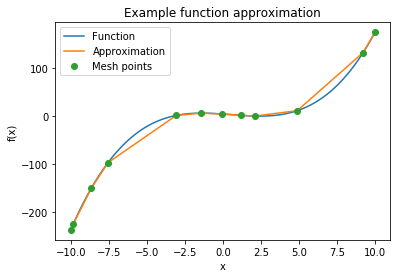

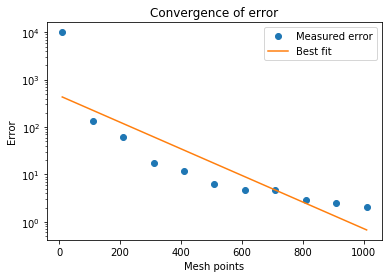

10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
All tests passed


In [73]:
n_tests = 500
for i in range(n_tests):
  if i % (n_tests // 10) == 0:
    print(f"{100 * (i / n_tests)} %")
  test_1D(i == 0)
print("All tests passed")

All the tests pass, the approximation looks reasonable given the function and the error decreases as we increase the number of mesh points implying convergence.

# **Discussion**

We conclude that the implementation works, but it is not written in a way that generalizes well for nonlinear $\phi$ or multidimensional meshes (for which we instead could have followed algorithm 9.2).